# Use Case: Resistance Dominant Lines

Developed by Mike Bardwell. University of Alberta. 2018

In [1]:
import keras
from keras.models import model_from_json
import numpy as np
import matplotlib.pyplot as plt
import time

import sys; sys.path.append('../'); sys.path.append('../../'); sys.path.append('../utils')
from powerflowsim import PowerFlowSim
from montecarlo import generateJson
from regression_tools import TrainANN, TrainRNN, NormalEquation

Using TensorFlow backend.
C:\Users\mikey\Anaconda3\envs\microgrid_workcomp\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
C:\Users\mikey\Anaconda3\envs\microgrid_workcomp\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Power System Load Flow

In [2]:
# model filename
topology = 'radial'
number_of_houses = 10000
number_of_timestamps = 4999
r = 0.001
x = 0.001
usecase = '_Rdominantlines'
model_name = topology + '_' + str(number_of_houses) + 'houses_' + str(number_of_timestamps) + 'timestamps' + usecase

In [3]:
# Ensure JSON file is available
timestamp_start = time.time()
generateJson(number_of_houses, 'mikework', False)

In [4]:
# Initialise power flow sim
pfs = PowerFlowSim(number_of_timestamps, 
                   topology,  
                   '../_configs/montecarlo' + str(number_of_houses) + '.json')

In [5]:
# Similar to nrPFSim
pfs.setupBuses()
pfs.setupGenerators()
pfs.setupLoads()
pfs.setupLines(rlines = r, xlines = x)

pfs.network.pf() # non-linear Newton Raphson power flow

showall = False
if showall:
    pfs.plotLoads()
    pfs.plotGenerators()
    pfs.plotNodeVoltages()
    pfs.plotLineLoading()
    pfs.boxPlots()

pfs.toArrays(True, True)

timestamp_end = time.time()
print(timestamp_end - timestamp_start)

C:\Users\mikey\Anaconda3\envs\microgrid_workcomp\lib\site-packages\pypsa\components.py:758: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  keys=self.passive_branch_components)


2889.9526937007904


In [6]:
# prepare load profiles
load_profile = []
for agent in pfs.sim.participants:
    if agent.devices['load'] == None:
        continue
    else:
        load_profile.append(agent.devices['load'].offline_profile['profile'])
load_profile = np.array(load_profile).T

print(pfs.nodeloads.shape, pfs.nodevoltages.shape)

(4999, 10000) (4999, 10000)


# Normal Equation

In [7]:
start = time.time()
ne = NormalEquation(pfs.nodeloads, pfs.nodevoltages)
ne.calculateTheta()
ne.calculateBias()
ne.evaluateModel()
end = time.time()
print(end - start)

normal equation mse: 17339550287008.365, mae: 671.631739844594
357.0370225906372


# Machine Learning

## RNN

In [8]:
# start = time.time()
# rnn = TrainRNN(pfs.nodeloads, pfs.nodevoltages)
# rnn.buildModel()
# rnn.trainModel()
# rnn.evaluateModel()
# end = time.time()
# print(end - start)

## DNN

In [9]:
repeat = False

ANN regression loss: 6.477158985695178e-08, mae: 0.00013062590333696653


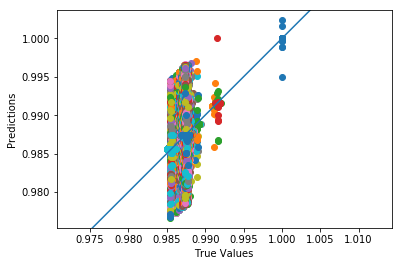

KeyboardInterrupt: 

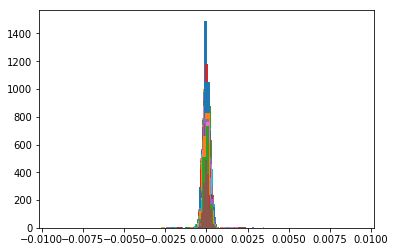

In [10]:
# ANN function mapping
trainpercentage = 0.7

if repeat:
    ann.trainModel()
    ann.evaluateModel()
    ann.predictWithModel()
    count += 1
    print('Trained {} times'.format(count))
else:
    start = time.time()
    ann = TrainANN(pfs.nodeloads, pfs.nodevoltages, trainpercentage)
    ann.buildModel()
    ann.trainModel()
    ann.evaluateModel()
    ann.predictWithModel()
    repeat = True; count = 1
    end = time.time()
    print(end - start)
    
filename = topology + '_' + str(number_of_houses) + 'houses_' + str(number_of_timestamps) + 'timestamps' + usecase

ann.saveModel(filename)
print('saved filename: {}'.format(filename))

# Comparing PSLF, ANN, NE

In [ ]:
plotting_timestamps = 25
x_axis = [i for i in range(plotting_timestamps)]


# Load profile

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k') # resize subplots for readability
from pylab import *
import math
for i in range(number_of_houses):
    side_length = math.ceil(np.sqrt(number_of_houses))
    subplot(side_length, side_length, i+1)
    title('Load at Node ' + str(i))
    plot(x_axis, load_profile.T[i][0:plotting_timestamps])

In [ ]:
def accessPSLFVoltages(node, pfs, number_of_timestamps):
    """
    :type node: int, pfs: PowerFlowSim class
    :rtype np.array of voltage values for node
    """
    name = pfs.network.buses_t['v_mag_pu'].keys()[node]
    return pfs.network.buses_t.v_mag_pu[name][0:number_of_timestamps]

def accessNEVoltages(node, load_profile, number_of_timestamps):
    """
    :type: node: int, model: numpy array, load_profile: numpy array, number_of_timestamps: int
    :rtype: np.array of voltage values for node
    """
    predictions = ne.predictWithModel(load_profile)
    if node == 0:
        return np.ones(number_of_timestamps)
    else:
        return predictions.T[node][0:number_of_timestamps]

def accessANNVoltages(node, model, load_profile, number_of_timestamps):
    """
    :type node: int, model: Keras model, load_profile: numpy array, number_of_timestamps: int
    :rtype np.array of voltage values for node
    """
    predictions = model.predict(load_profile)
    if node == 0:
        return np.ones(number_of_timestamps)
    else:
        return predictions.T[node][0:number_of_timestamps]

In [ ]:
# Voltage Subplots

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k') # resize subplots for readability

for i in range(number_of_houses):
    side_length = math.ceil(np.sqrt(number_of_houses))
    ax1 = subplot(side_length, side_length, i+1)
    ax2 = ax1.twinx()
    ax1.plot(x_axis, accessNEVoltages(i, load_profile, plotting_timestamps), 'b',
             x_axis, accessANNVoltages(i, ann.model, load_profile, plotting_timestamps), 'r',
             x_axis, accessPSLFVoltages(i, pfs, plotting_timestamps), 'g')
    ax2.plot(x_axis, load_profile.T[i][0:plotting_timestamps], '--k')
    ax1.legend(['NE Predicted Voltage', 'ANN Predicted Voltage', 'PSLF Calculated Voltage'])
    ax2.legend(['Load Profile'])
    ax1.set_title('Voltages at Node' + str(i))

In [ ]:
# Voltage plot for saving
plt.plot(x_axis, accessNEVoltages(1, load_profile, plotting_timestamps), 'ob',
         x_axis, accessANNVoltages(1, ann.model, load_profile, plotting_timestamps), 'r', 
         x_axis, accessPSLFVoltages(1, pfs, plotting_timestamps), 'g') 
plt.xlabel('Timestamps')
plt.ylabel('Node Voltages')
plt.legend(['NE Predicted Voltage', 'ANN Predicted Voltage', 'PSLF Calculated Voltage'])

from textwrap import wrap
title = 'Predicted and Calculated Voltages at One Node in Line-Resistance Dominant Grid'
plt.title('\n'.join(wrap(title,50)))
savetitle = 'usecase_' + str(number_of_houses) + 'houses_' + topology + usecase + 'grid.pdf'
plt.savefig(savetitle, transparent = True)
print('Saved as {}'.format(savetitle))

plt.show()

# Testing Against a Different Load Profile 

In [ ]:
# Initialise power flow sim
pfs2 = PowerFlowSim(number_of_timestamps, 
                   topology,  
                   '../_configs/7houses_landmarkdata.json')

In [ ]:
# Similar to nrPFSim
pfs2.setupBuses()
pfs2.setupGenerators()
pfs2.setupLoads()
pfs2.setupLines(rlines = r, xlines = x)

pfs2.network.pf() # non-linear Newton Raphson power flow

showall = False
if showall:
    pfs2.plotLoads()
    pfs2.plotGenerators()
    pfs2.plotNodeVoltages()
    pfs2.plotLineLoading()
    pfs2.boxPlots()

pfs2.toArrays(True, True)

In [ ]:
# prepare load profiles
load_profile2 = []
for agent in pfs2.sim.participants:
    if agent.devices['load'] == None:
        continue
    else:
        load_profile2.append(agent.devices['load'].offline_profile['profile'])
load_profile2 = np.array(load_profile2).T

In [ ]:
# Voltage subplots on Landmark housing data

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k') # resize subplots for readability

for i in range(number_of_houses):
    side_length = math.ceil(np.sqrt(number_of_houses))
    ax1 = subplot(side_length, side_length, i+1)
    ax2 = ax1.twinx()
    ax1.plot(x_axis, accessNEVoltages(i, load_profile2, plotting_timestamps), 'b',
             x_axis, accessANNVoltages(i, ann.model, load_profile2, plotting_timestamps), 'r',
             x_axis, accessPSLFVoltages(i, pfs2, plotting_timestamps), 'g')
    ax2.plot(x_axis, load_profile2.T[i][0:plotting_timestamps], '--k')
    ax1.set_title('Voltages at Node' + str(i))
    ax1.legend(['NE Predicted Voltage', 'ANN Predicted Voltage', 'PSLF Calculated Voltage'])